### Лабораторная работа №5

В ходе работы выполняется несколько заданий.

1. В прилагаемом  файле weather.csv содержатся данные многолетних наблюдений температуры. Усреднив результаты измерений, с помощью частотной фильтрации нужно, применив отсечение по некоторому порогу спектральной плотности мощности, убрать посторонние шумы и определить регулярный цикл с которым температура на планете меняется. Ответ, в принципе, известен, это 11-летний цикл активности солнца. В этой работе можно его подтвердить численно. Температура в файле указана не в градусах, а в десятых долях градуса, т.е. ее нужно делить на 10 или чтобы сразу получить среднюю дневную (tmax+tmin)/20

In [147]:
import pandas as pd
import numpy as np
f = pd.read_csv( 'weather.csv',      # считывание данных из файла в датафрейм
                 na_values=(-9999),  # указание преобразовать это значение в нечисловое NaN при считывании  
                 parse_dates=['DATE']) # распарсить колонку "DATE" как дату
f.columns

Index(['STATION', 'DATE', 'PRCP', 'TMAX', 'TMIN'], dtype='object')

In [150]:
np.fft.fft?

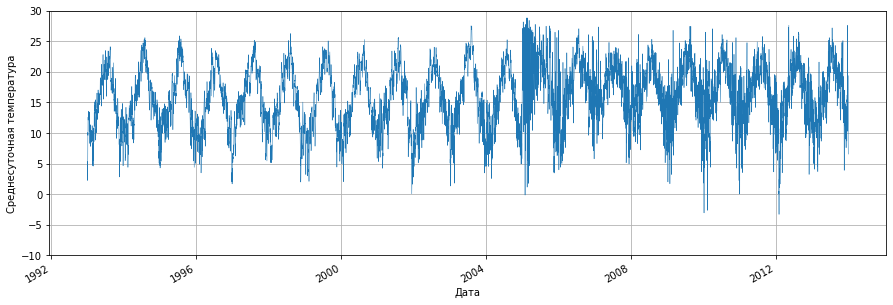

In [148]:
avg=f.dropna().groupby('DATE').mean()
avg.head()

date = avg.index # Создаем отдельную переменную дата для оси абсцисс
Tavg=(avg['TMAX']+avg['TMIN'])/20.0

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

Tavg.plot(ax=ax, lw=0.5)
ax.set_ylim(-10, 30)

ax.set_xlabel('Дата')
ax.set_ylabel('Среднесуточная температура')

plt.grid()

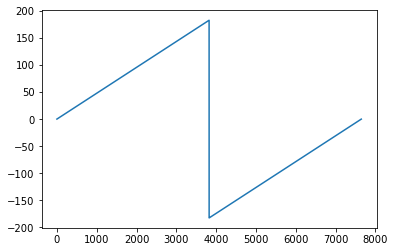

In [74]:
import scipy as sp
import scipy.fftpack

temp_fft = np.fft.fft(Tavg) # получаем Фурье-образ (частотное представление) для набора данных
temp_psd = np.abs(temp_fft) ** 2 # считаем спектральную плотность мощности
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1./365) # получаем набор частот для нашей выборки. Половина из них положительные.
plt.plot(fftfreq)                                  # шаг по времени в нашей выборке 1 день, 1/365 года
i = fftfreq > 0 # создаем индекс через булевое выражение


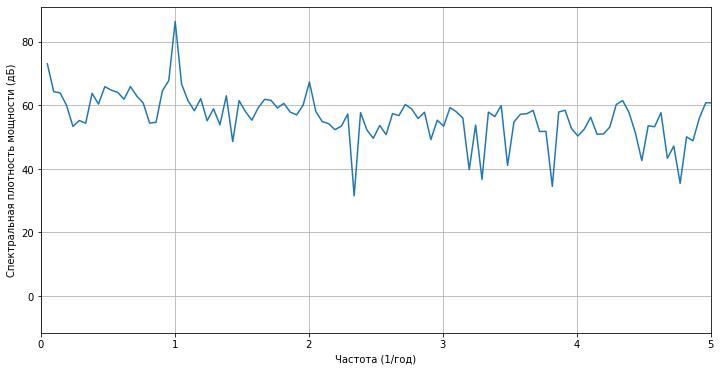

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # создаем область рисования
# ax.plot(fftfreq[i], temp_psd[i]) # выводим на график в обычном масштабе амплитуды компоненты
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i])) # выводим на график в логарифмическом масштабе амплитуды компоненты
                                                    # спектральной плотности мощности для соответствующих частот 
ax.set_xlim(0, 5) # вывод можно ограничить несколькими годами, т.к максимальные значения находятся вначале.
ax.set_xlabel('Частота (1/год)')
ax.set_ylabel('Спектральная плотность мощности (дБ)')

plt.grid()



Text(0, 0.5, 'Средняя температура')

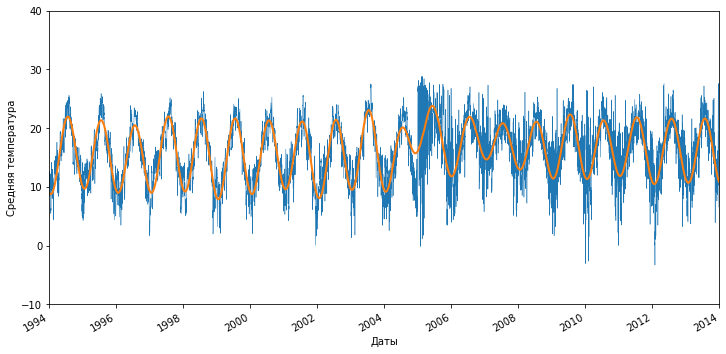

In [156]:
import datetime

temp_fft_bis = temp_fft.copy() # сделаем копию данных датафрейма для частотных отсчетов
temp_fft_bis[np.abs(fftfreq) > 1.2] = 0 # так как нас интересуют низкочастотные, долговременные колебания температуры,
                                        # обнулим все частоты, которые быстрее примерно 1 года
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis)) # возьмем реальную часть от того что получилось

fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # выведем на общий график результат
Tavg.plot(ax=ax, lw=.5)                       # рассчитанная средняя температура 
ax.plot_date(date, temp_slow, '-', lw=2)            # низкочастотные колебания температуры в частотном спектре
ax.set_xlim(datetime.date(1994, 1, 1),
            datetime.date(2014, 1, 1))
ax.set_ylim(-10, 40)
ax.set_xlabel('Даты')
ax.set_ylabel('Средняя температура')

Вывод: Годичный цикл виден (ещё на спектрограмме), для подтверждения 11-ти летнего цикла недостаточно данных

2. Используя образец, выполнить частотную фильтрацию изображения dog2.jpg

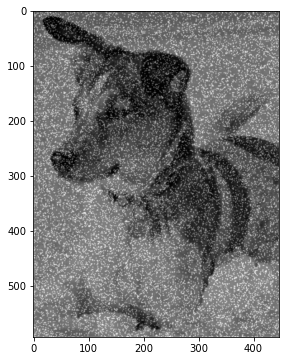

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
import skimage.io as io
image = io.imread('dog2.jpg') # Чтение изображения из файла в переменную

image = np.mean(image, -1)                # Преобразование в двумерное с градациями серого
M, N = image.shape
f, ax = plt.subplots(figsize=(6, 6)) # Создание области рисования
ax.imshow(image,cmap='gray')

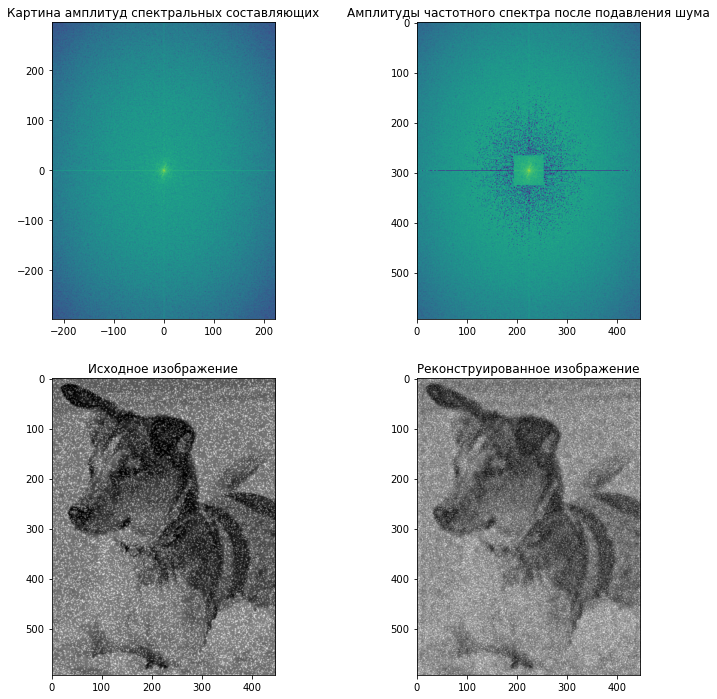

In [145]:
F = fftpack.fftn(image) # Преобразование с помощью многомерного БПФ в частотную область

F_magnitude = np.abs(F) # Расчет амплитуд спектральных составляющих
F_magnitude = fftpack.fftshift(F_magnitude) # перемещение точки нулевой частоты в середину спектра

# f, ax = plt.subplots(figsize=(6, 6))

# ax.imshow(np.log(1 + F_magnitude), cmap='viridis',
#           extent=(-N // 2, N // 2, -M // 2, M // 2)) # вывод на график амплитуд частотного спектра
# ax.set_title('Картина амплитуд спектральных составляющих');


# Обнуление амплитуд частотного спектра, отстоящих от центра на заданное расстояние
K = 30

old_F_magnitude = F_magnitude.copy()
F_magnitude[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0

# создание логического массива той же размерности с 1-ми для амплитуд меньше 98 перцентиля
peaks = F_magnitude < np.percentile(F_magnitude, 98)

# обратный сдвиг для соответствия отсчетам оригинального спектра
peaks = fftpack.ifftshift(peaks)

# Создание копии комплексных спектральных отсчетов (чтобы сохранить неизменным этот массив F)
F_dim = F.copy()

# Собственно, фильтрация, т.е. обнуление малозначащих компонент
F_dim = F_dim * peaks.astype(int)

# Восстановление изображение из отфильтрованного образа
# Так как для востановления изображения нужна только реальная часть, берем только ее
image_filtered = np.real(fftpack.ifft2(F_dim))

f, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 12)) # вывод на график частотного спектра после фильтрации
ax12.imshow(fftpack.fftshift(np.log10(1 + np.abs(F_dim))), cmap='viridis')
ax12.set_title('Амплитуды частотного спектра после подавления шума')

ax22.imshow(image_filtered,cmap='gray') # и самого изображения
ax22.set_title('Реконструированное изображение')

ax11.imshow(np.log(1+old_F_magnitude), cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2)) # вывод на график амплитуд частотного спектра
ax11.set_title('Картина амплитуд спектральных составляющих');

ax21.imshow(image,cmap='gray')
ax21.set_title('Исходное изображение');
